In [1]:
from dstreader import DstFile

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from pathlib import Path
from datetime import datetime

In [2]:
# to let python import packages in project root
import sys
sys.path.insert(0, str(Path("..").resolve()))

In [3]:
from data_extraction.filenames import set_data_dir, get_dst_file, DstFileType

set_data_dir(Path("../data"))
dat_name = "DAT009512"

all_dst = DstFile(get_dst_file(dat_name, DstFileType.FULL))
mu_dst = DstFile(get_dst_file(dat_name, DstFileType.MU))
el_dst = DstFile(get_dst_file(dat_name, DstFileType.EL))
gamma_dst = DstFile(get_dst_file(dat_name, DstFileType.GAMMA))
hadrons_dst = DstFile(get_dst_file(dat_name, DstFileType.HADRONS))
noise_dst = DstFile(get_dst_file(dat_name, DstFileType.NOISE))


dst_files = [all_dst, mu_dst, el_dst, gamma_dst, hadrons_dst, noise_dst]
dst_file_labels = ["total", r"$\mu^{+/-}$", r"$e^{+/-}$", r"$\gamma$", "hadrons", "noise"]

In [14]:
for dst in dst_files:
    dst.open()
event_iters = [dst.events() for dst in dst_files]

Each run of the cell below = 1 event from dst files, selecting top waveforms by integral

Event datetime: 2008-06-04 22:50:38.850910


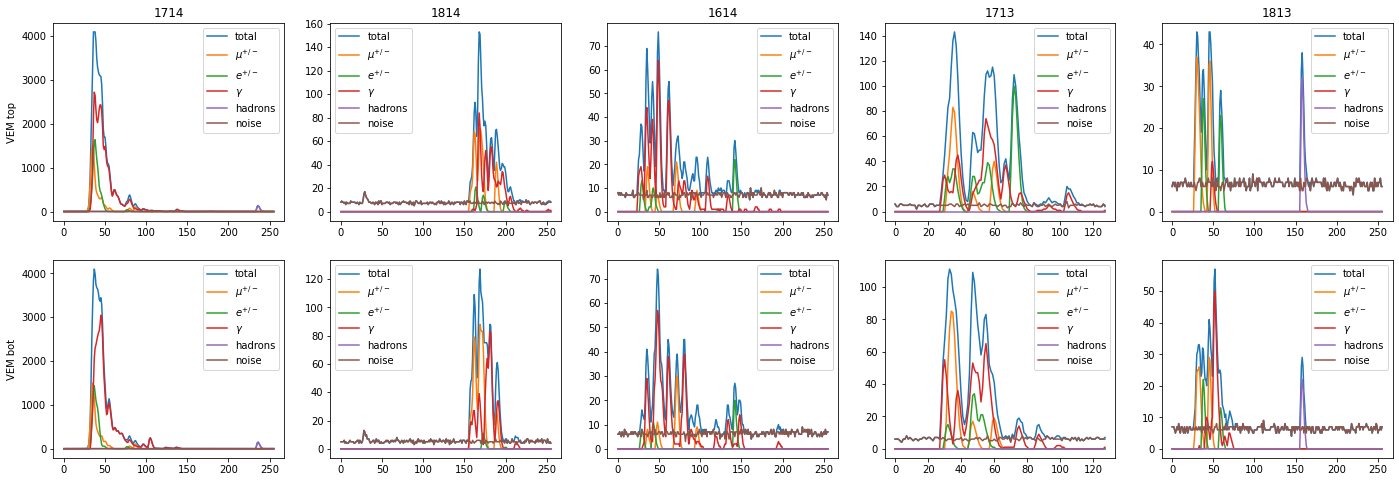

In [20]:
from data_extraction.waveform_processing import assemble_waveforms, get_datetime

n_top_waveforms = 5

fig, axes = plt.subplots(nrows=2, ncols=n_top_waveforms, figsize=(24, 8))

detectors_to_plot = None

datetime_printed = False

for dst_label, event_iter, dst in zip(dst_file_labels, event_iters, dst_files):
    next(event_iter)
    rusdraw = dst.get_bank('rusdraw')
    if rusdraw['nofwf'] == 0:
        continue
    fadc = rusdraw['fadc']
    wf_id = rusdraw['wf_id']
    xxyy = rusdraw['xxyy']

    if not datetime_printed:
        print(f"Event datetime: {get_datetime(rusdraw)}")
        datetime_printed = True

    waveform_parts_by_detector = defaultdict(dict)
    for i in range(rusdraw['nofwf']):
        waveform_parts_by_detector[xxyy[i]][wf_id[i]] = fadc[i]

    waveforms_by_detector = {xxyy_: assemble_waveforms(wfp) for xxyy_, wfp in waveform_parts_by_detector.items()}

    if detectors_to_plot is None:
        # looking for max integral waveforms
        detector_with_integral = [
            (xxyy_, np.sum(wf_top) + np.sum(wf_bot))
            for xxyy_, (wf_top, wf_bot) in waveforms_by_detector.items()
        ]
        detector_with_integral.sort(key=lambda d_i: d_i[1], reverse=True)
        detectors_to_plot = [xxyy_ for (xxyy_, _) in detector_with_integral[:n_top_waveforms]]

    for icol, xxyy_ in enumerate(detectors_to_plot):
        for irow, wf in enumerate(waveforms_by_detector[xxyy_]):
            ax: plt.Axes = axes[irow][icol]
            if irow == 0:
                ax.set_title(str(xxyy_))
            if icol == 0:
                ax.set_ylabel("VEM " + ("top" if irow == 0 else "bot"))
            ax.plot(wf, label=dst_label)
            ax.legend()

plt.savefig("../pics/waveforms-example.png", bbox_inches="tight")
plt.show()


In [7]:
print(rusdraw.doc)


integer4 event_num;		                        /* event number */
integer4 event_code;                                  /* 1=data, 0=Monte Carlo */
integer4 site;                                        /* BR=0,LR=1,SK=2,BRLR=3,BRSK=4,LRSK=5,BRLRSK=6 */
integer4 run_id[3];                                   /* run number for [0]-BR,[1]-LR,[2]-SK, -1 if irrelevant */
integer4 trig_id[3];		                        /* event trigger id for each tower, -1 if irrelevant */
integer4 errcode;                                     /* should be zero if there were no readout problems */
integer4 yymmdd;		                        /* event year, month, day */
integer4 hhmmss;		                        /* event hour minut second */
integer4 usec;		                        /* event micro second */
integer4 monyymmdd;                                   /* yymmdd at the beginning of the mon. cycle used in this event */
integer4 monhhmmss;                                   /* hhmmss at the beginning of the mon. c

In [21]:
for dst in dst_files:
    dst.close()

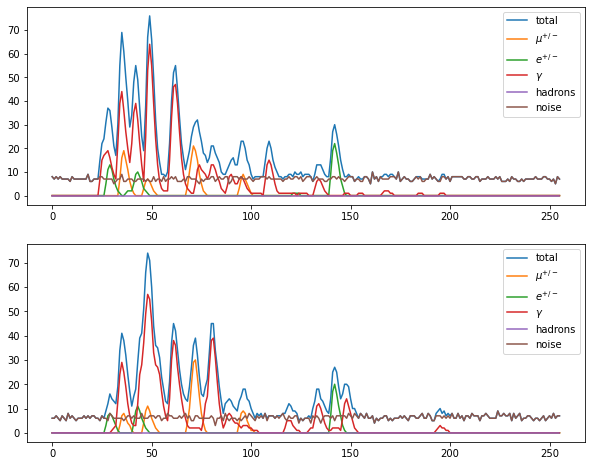

In [22]:
from data_extraction.waveform_processing import get_datetime

# plotting specific event (by precise datetime) and specific detector (by xxyy)
target_dt = datetime.fromisoformat("2008-06-04 22:50:38.850910")
target_xxyy = 1614

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

target_detector_waveforms_by_label = dict()

with all_dst, mu_dst, el_dst, gamma_dst, hadrons_dst, noise_dst:
    for dst, label in zip(dst_files, dst_file_labels):
        for _ in dst.events():
            rusdraw = dst.get_bank('rusdraw')
            datetime_ = get_datetime(rusdraw)
            if datetime_ != target_dt:
                continue

            fadc = rusdraw['fadc']
            wf_id = rusdraw['wf_id']
            xxyy = rusdraw['xxyy']
            waveform_parts_by_detector = defaultdict(dict)
            for i in range(rusdraw['nofwf']):
                waveform_parts_by_detector[xxyy[i]][wf_id[i]] = fadc[i]    
            waveforms_by_detector = {xxyy_: assemble_waveforms(wfp) for xxyy_, wfp in waveform_parts_by_detector.items()}

            target_detector_waveforms_by_label[label] = waveforms_by_detector[target_xxyy]
            break
        else:
            raise ValueError(f"Event with target datetime {target_dt} not found")

for label, waveforms in target_detector_waveforms_by_label.items():
    for irow, waveform in enumerate(waveforms):
        ax: plt.Axes = axes[irow]
        ax.plot(waveform, label=label)
        ax.legend()


plt.savefig(f"../pics/anomalous-mu-{target_dt}-{target_xxyy:04}.png", bbox_inches="tight")
plt.show()